# Calibration of the school model with age dependence based on empirical data

In [ ]:
import numpy as np
import pandas as pd
import numpy as np
from os.path import join
import json

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# custom functions to run the calibration simulations
import calibration_functions as cf

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

## Empirical observations

In [2]:
# school types over which the calibration us run
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']

In [3]:
empirical_data_src = '../../data/calibration/empirical_observations'

# distribution of outbreak sizes by school type
outbreak_sizes = pd.read_csv(\
            join(empirical_data_src, 'empirical_outbreak_sizes.csv'))
# ratio of infections in the student and teacher groups
group_distributions = pd.read_csv(\
            join(empirical_data_src, 'empirical_group_distributions.csv'))
# ratio of index cases in the student and teacher groups
agent_index_ratios = pd.read_csv(\
            join(empirical_data_src, 'empirical_index_case_ratios.csv'))
agent_index_ratios.index = agent_index_ratios['school_type']
# ratio of symptomatic cases in the student and teacher groups
symptomatic_case_ratios = pd.read_csv(\
            join(empirical_data_src, 'empirical_symptomatic_case_ratios.csv'))

In [4]:
# note: these are the number of clusters per school type from the slightly older
# data version (November 2020). For primary and lower secondary school types,
# the counts are split evenly between schools with and without daycare. 
counts = pd.DataFrame({'type':['primary', 'primary_dc', 
                               'lower_secondary', 'lower_secondary_dc',
                               'upper_secondary', 'secondary'],
                      'count':[33.5, 33.5, 90, 90, 116, 70]})

counts.index = counts['type']
counts = counts.drop(columns=['type'])
# The cluster counts are used to weigh the respective school type in the 
# calibration process.
counts['weight'] = counts['count'] / counts['count'].sum()

## Simulation settings

In [5]:
# List of prevention measures that were in place in schools in the weeks 36-45
# of the year 2020 in Austrian schools. This list was compiled from information
# collected in interviews with teachers of different school types. NOTE: so far
# there are no recorded differences between school types.
with open('params/calibration_measures.json', 'r') as fp:
    prevention_measures = json.load(fp)
# simulation parameters, specifically the
# - base transmission risk (calibrated from household transmissions)
# - subclinical transmission modifier (literature value)
# - exposure duration, time until symtpoms and infection duration (lit. values)
# - age symptom discount (fit to empirical observations)
with open('params/calibration_simulation_parameters.json', 'r') as fp:
    simulation_params = json.load(fp)
# characteristics (# classes, # students / class, # teachers) of the "average" 
# school, depending on school type. These characteristics were determined in 
# interviews with Austrian teachers and from statistics about Austrian schools 
# (year 2017/18, page 10: https://www.bmbwf.gv.at/Themen/schule/schulsystem/gd.html)
# NOTE: "students" indicates the number of students per class
with open('params/calibration_school_characteristics.json', 'r') as fp:
    school_characteristics = json.load(fp)

## Simulation function

In [6]:
def run(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters test_type, 
        index_case, e_screen_range and r_screen_range that are passed to the
        simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, intermediate_contact_weight, far_contact_weight,\
                age_transmission_discount = params

    # run the ensemble with the given parameter combination and school type
    ensemble_results = cf.run_ensemble(N_runs, school_type,
            intermediate_contact_weight, far_contact_weight, 
            age_transmission_discount, prevention_measures,
            school_characteristics, agent_index_ratios,
            simulation_params, contact_network_src, ensmbl_dst)

    # calculate the difference between the ensemble characteristics
    # (outbreak distribution, ratio of student to teacher cases)
    row = cf.evaluate_ensemble(ensemble_results, school_type,
            intermediate_contact_weight, far_contact_weight,
            age_transmission_discount, outbreak_sizes, group_distributions)
    
    return row

## Fine grid search with age dependence

### Create calibration parameter grid

In [7]:
# optimum far contact weight from coarse calibration without age dependence
# see script calibration_without_age_dependence.ipyn
opt_contact_weight_coarse = 0.27

In [8]:
## grid of parameters that need to be calibrated
N_runs = 500

# school types over which the calibration us run
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']

# the contact weight is the modifier by which the base transmission risk (for
# household transmissions) is multiplied for contacts of type "intermediate" 
# and of type "far". Parameter values are chosen around the optimum from the
# previous random sampling search, passed to the script via the command line.
contact_weights_fine = np.hstack([
    np.arange(opt_contact_weight_coarse - 0.05, 
              opt_contact_weight_coarse, 0.01),
    np.arange(opt_contact_weight_coarse, 
              opt_contact_weight_coarse + 0.06, 0.01)
    ])

# the age_transmission_discount sets the slope of the age-dependence of the 
# transmission risk. Transmission risk for adults (age 18+) is always base 
# transmission risk. For every year an agent is younger than 18 years, the
# transmission risk is reduced. Parameter values are chosen around the optimum 
# from the previous random sampling search
age_transmission_discounts_fine = [-0.01,-0.02,-0.03,-0.04,-0.05,-0.06, 
                                   -0.07, -0.08, -0.09]

contact_weights_fine = np.asarray([round(i, 2) \
            for i in contact_weights_fine])


print('contact weiths: ', contact_weights_fine)
print('age discounts: ', age_transmission_discounts_fine)

# list of all possible parameter combinations from the grid
# Note: the age transmission discount is set to 0 for all parameter
# combinations here
screening_params = [(N_runs, i, j, j, k) for i in school_types \
                    for j in contact_weights_fine \
                    for k in age_transmission_discounts_fine]

print('There are {} parameter combinations to sample.'.format(len(screening_params)))

contact weiths:  [0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32]
age discounts:  [-0.01, -0.02, -0.03, -0.04, -0.05, -0.06, -0.07, -0.08, -0.09]
There are 594 parameter combinations to sample.


### Run the sampling

In [109]:
%%time
contact_network_src = '../../data/contact_networks/calibration'
ensmbl_dst = '../../data/calibration/simulation_results/ensembles'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

rows = []
for row in tqdm(pool.imap_unordered(func=run, iterable=screening_params),
                total=len(screening_params)):
        rows.append(row)

# turn off your parallel workers 
pool.close()

# format and dump the results to disk
dst = '../../data/calibration/simulation_results'
results = pd.DataFrame()
for row in rows:
    results = results.append(row, ignore_index=True)
    
results.reset_index()
index_cols = ['school_type', 'intermediate_contact_weight',
              'far_contact_weight', 'age_transmission_discount']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst,'calibration_results_fine_sampling_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 600/600 [19:54:15<00:00, 119.43s/it]    


CPU times: user 7.04 s, sys: 1.41 s, total: 8.45 s
Wall time: 19h 54min 17s


,school_type,intermediate_contact_weight,far_contact_weight,age_transmission_discount,chi2_distance_distro,chi2_distance_size,chi2_distance_total,sum_of_squares_distro,sum_of_squares_size,sum_of_squares_total
0,primary,0.26,0.25,0.0,0.089444,0.054324,0.143768,0.132040,0.068568,0.200608
1,primary,0.25,0.24,0.0,0.059658,0.066652,0.126310,0.088069,0.083824,0.171893
2,primary,0.25,0.21,0.0,0.078605,0.120814,0.199419,0.116039,0.154010,0.270049


### Analyze the fine grid search

#### Collect the results

In [14]:
dst = '../../data/calibration/simulation_results'
N = 2000
results_fine = pd.DataFrame()
for st in school_types:
    tmp = pd.read_csv(join(dst, 'calibration_results_fine_sampling_{}_{}.csv'\
                          .format(N, st)))
    results_fine = pd.concat([results_fine, tmp])
    
results_fine.to_csv(join(dst, 'calibration_results_fine_sampling_{}.csv'\
                        .format(N)), index=False)

In [15]:
results_fine = results_fine.sort_values(by=['school_type',
                    'intermediate_contact_weight', 'age_transmission_discount'])
results_fine = results_fine.reset_index(drop=True)

results_fine['chi2_distance_total'] = \
        results_fine['chi2_distance_size'] + \
        results_fine['sum_of_squares_distro']

results_fine['chi2_distance_total_weighted'] = \
        results_fine['chi2_distance_total']

for i, row in results_fine.iterrows():
    st = row['school_type']
    weight = counts.loc[st, 'weight']
    error = row['chi2_distance_total']
    results_fine.loc[i, 'chi2_distance_total_weighted'] = error * weight

#### Aggretage results

In [16]:
agg_results_fine = results_fine.groupby(['intermediate_contact_weight',
                                         'age_transmission_discount']).sum()
opt_fine = agg_results_fine.loc[\
        agg_results_fine['chi2_distance_total_weighted'].idxmin()].name
opt_contact_weight_fine = opt_fine[0]
opt_age_transmission_discount_fine = opt_fine[1]

print('optimal grid search parameter combination:')
print('\t intermediate contact weight: {:1.3f}'\
      .format(opt_contact_weight_fine))
print('\t age transmission discount: {:1.3f}'\
      .format(opt_age_transmission_discount_fine))

optimal grid search parameter combination:
	 intermediate contact weight: 0.290
	 age transmission discount: -0.010


In [17]:
img_fine = np.zeros((len(contact_weights_fine),
                len(age_transmission_discounts_fine)))
for i, cw in enumerate(contact_weights_fine):
    for j, atd in enumerate(age_transmission_discounts_fine):
        cw = round(cw, 2)
        atd = round(atd, 2)
        try:
            img_fine[i, j] = agg_results_fine\
                .loc[cw, atd]['chi2_distance_total_weighted']
        except KeyError:
            img_fine[i, j] = np.nan

#### Plot results

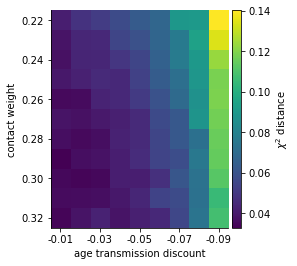

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))

im = ax.imshow(img_fine)
ax.set_yticks(range(len(contact_weights_fine))[::2])
ax.set_yticklabels(['{:1.2f}'.format(cw) for \
                    cw in contact_weights_fine[::2]])
ax.set_xticks(range(len(age_transmission_discounts_fine))[::2])
ax.set_xticklabels(['{:1.2f}'.format(atd) for \
                    atd in age_transmission_discounts_fine[::2]])

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('$\chi^2$ distance')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('contact weight')
ax.set_xlabel('age transmission discount');

## Very fine grid search with age dependence

### Create the parameter grid

In [26]:
N_runs = 4000
opt_contact_weight_coarse = float(opt_contact_weight_fine)
# the contact weight is the modifier by which the base transmission risk (for
# household transmissions) is multiplied for contacts of type "intermediate" 
# and of type "far". Parameter values are chosen around the optimum from the
# previous random sampling search, passed to the script via the command line.
contact_weights_veryfine = np.hstack([
    np.arange(opt_contact_weight_coarse - 0.06, 
              opt_contact_weight_coarse, 0.01),
    np.arange(opt_contact_weight_coarse, 
              opt_contact_weight_coarse + 0.061, 0.01)
    ])

# the age_transmission_discount sets the slope of the age-dependence of the 
# transmission risk. Transmission risk for adults (age 18+) is always base 
# transmission risk. For every year an agent is younger than 18 years, the
# transmission risk is reduced. Parameter values are chosen around the optimum 
# from the previous random sampling search
age_transmission_discounts_veryfine = [0.00, -0.0025, -0.005, -0.0075, -0.01,
                                   -0.0125, -0.015, -0.0175, -0.02,
                                   -0.0225, -0.025, -0.0275, -0.03]

contact_weights_veryfine = np.asarray([round(i, 2) \
            for i in contact_weights_veryfine])


print('contact weiths: ', contact_weights_veryfine)
print('age discounts: ', age_transmission_discounts_veryfine)

# list of all possible parameter combinations from the grid
# Note: the age transmission discount is set to 0 for all parameter
# combinations here
screening_params = [(N_runs, i, j, j, k) for i in school_types \
                    for j in contact_weights_veryfine \
                    for k in age_transmission_discounts_veryfine]


print('There are {} parameter combinations to sample with {} runs each.'\
  .format(len(screening_params), N_runs))

contact weiths:  [0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35]
age discounts:  [0.0, -0.0025, -0.005, -0.0075, -0.01, -0.0125, -0.015, -0.0175, -0.02, -0.0225, -0.025, -0.0275, -0.03]
There are 1014 parameter combinations to sample with 4000 runs each.


### Run the sampling

In [59]:
%%time
contact_network_src = '../../data/contact_networks/calibration'
ensmbl_dst = '../../data/calibration/simulation_results/ensembles_test'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

rows = []
for row in tqdm(pool.imap_unordered(func=run, iterable=screening_params[0:10]),
                total=len(screening_params)):
        rows.append(row)

# turn off your parallel workers 
pool.close()

# format and dump the results to disk
dst = '../../data/calibration/simulation_results'
results = pd.DataFrame()
for row in rows:
    results = results.append(row, ignore_index=True)
    
results.reset_index()
index_cols = ['school_type', 'intermediate_contact_weight',
              'far_contact_weight', 'age_transmission_discount']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

#results.to_csv(join(dst,'calibration_results_fine_sampling_{}.csv'\
#                   .format(N_runs)), index=False)
results.head(3)

  1%|          | 10/864 [00:01<01:26,  9.87it/s]


CPU times: user 104 ms, sys: 72.6 ms, total: 176 ms
Wall time: 1.19 s


,school_type,intermediate_contact_weight,far_contact_weight,age_transmission_discount,chi2_distance_distro,chi2_distance_size,chi2_distance_total,sum_of_squares_distro,sum_of_squares_size,sum_of_squares_total
0,primary,0.24,0.24,-0.0125,NaN,0.142476,NaN,NaN,0.176209,NaN
1,primary,0.24,0.24,-0.0150,0.131197,0.452821,0.584017,0.193677,0.579194,0.772871
2,primary,0.24,0.24,-0.0225,0.048298,0.564163,0.612461,0.071299,0.698597,0.769896


### Analyze the very fine grid search all distance metrics

#### Collect ensemble results

In [ ]:
# Note: do not run again if ensemble distributions have already been calculated

# calculate the number of infected students and teachers for every run in
# the given ensemble and save them for later analysis
src = '../../data/calibration/simulation_results/ensembles_veryfine'
dst = '../../data/calibration/simulation_results/ensembles_veryfine_infected'

for i, ep in enumerate(screening_params):
    if i % 10 == 0:
        print('{}/{}'.format(i, len(screening_params)))
    cf.calculate_ensemble_distributions(ep, src, dst)

#### Calculate distance metrics overall distribution + ratio

In [28]:
# calculate the various distribution distances between the simulated and
# observed outbreak size distributions
src = '../../data/calibration/simulation_results/ensembles_veryfine_infected'

results_veryfine = pd.DataFrame()
for i, ep in enumerate(screening_params):
    _, school_type, icw, fcw, atd = ep
    if i % 100 == 0:
        print('{}/{}'.format(i, len(screening_params)))
    fname = 'school_type-{}_icw-{:1.2f}_fcw-{:1.2f}_atd-{:1.4f}_infected.csv'\
        .format(school_type, icw, fcw, atd)
    ensemble_results = pd.read_csv(join(src, fname), 
            dtype={'infected_students':int, 'infected_teachers':int,
                   'infected_total':int, 'run':int})
    row = cf.calculate_distances(ensemble_results, school_type, icw, fcw, atd,
                       outbreak_sizes, group_distributions)
    
    results_veryfine = results_veryfine.append(row, ignore_index=True)

0/1014
100/1014
200/1014
300/1014
400/1014
500/1014
600/1014
700/1014
800/1014
900/1014
1000/1014


In [29]:
# collection of different distance metrics to try
distance_cols = [
    'chi2_distance',
    'sum_of_squares',
    'bhattacharyya_distance',
    'pearsonr_difference',
    'spearmanr_difference',
    'qq_difference',
    'pp_difference'
]

In [30]:
results_veryfine = results_veryfine.sort_values(by=['school_type',
                'intermediate_contact_weight', 'age_transmission_discount'])
results_veryfine = results_veryfine.reset_index(drop=True)

for col in distance_cols:
    results_veryfine[col + '_total'] = results_veryfine[col + '_size'] + \
                    results_veryfine['sum_of_squares_distro']
    results_veryfine[col + '_total_weighted'] = results_veryfine[col + '_total']
    
    for i, row in results_veryfine.iterrows():
        st = row['school_type']
        weight = counts.loc[st, 'weight']
        error = row[col + '_total']
        results_veryfine.loc[i, col + '_total_weighted'] = error * weight

##### Aggretage results

In [31]:
agg_results_veryfine = results_veryfine\
    .drop(columns=['far_contact_weight'])\
    .rename(columns={'intermediate_contact_weight':'contact_weight'})\
    .groupby(['contact_weight',
              'age_transmission_discount'])\
    .sum()

for col in distance_cols:
    print(col)
    opt_veryfine = agg_results_veryfine.loc[\
            agg_results_veryfine[col + '_total_weighted'].idxmin()].name
    opt_contact_weight_veryfine = opt_veryfine[0]
    opt_age_transmission_discount_veryfine = opt_veryfine[1]

    print('optimal grid search parameter combination:')
    print('\t contact weight: {:1.3f}'\
          .format(opt_contact_weight_veryfine))
    print('\t age transmission discount: {:1.4f}'\
          .format(opt_age_transmission_discount_veryfine))
    print()

chi2_distance
optimal grid search parameter combination:
	 contact weight: 0.330
	 age transmission discount: -0.0075

sum_of_squares
optimal grid search parameter combination:
	 contact weight: 0.260
	 age transmission discount: 0.0000

bhattacharyya_distance
optimal grid search parameter combination:
	 contact weight: 0.240
	 age transmission discount: -0.0025

pearsonr_difference
optimal grid search parameter combination:
	 contact weight: 0.290
	 age transmission discount: -0.0150

spearmanr_difference
optimal grid search parameter combination:
	 contact weight: 0.230
	 age transmission discount: -0.0075

qq_difference
optimal grid search parameter combination:
	 contact weight: 0.350
	 age transmission discount: -0.0175

pp_difference
optimal grid search parameter combination:
	 contact weight: 0.270
	 age transmission discount: 0.0000



In [32]:
distance_images = {}
for col in distance_cols:
    img_veryfine = np.zeros((len(contact_weights_veryfine),
                    len(age_transmission_discounts_veryfine)))
    for i, cw in enumerate(contact_weights_veryfine):
        for j, atd in enumerate(age_transmission_discounts_veryfine):
            cw = round(cw, 2)
            atd = round(atd, 4)
            try:
                img_veryfine[i, j] = agg_results_veryfine\
                    .loc[cw, atd][col + '_total_weighted']
            except KeyError:
                print(atd)
                img_veryfine[i, j] = np.nan
    distance_images[col] = img_veryfine

In [33]:
img_first_component = np.zeros((len(contact_weights_veryfine),
                len(age_transmission_discounts_veryfine)))
for i, cw in enumerate(contact_weights_veryfine):
    for j, atd in enumerate(age_transmission_discounts_veryfine):
        cw = round(cw, 2)
        atd = round(atd, 4)
        try:
            img_first_component[i, j] = agg_results_veryfine\
                .loc[cw, atd]['sum_of_squares_distro']
        except KeyError:
            print(atd)
            img_first_component[i, j] = np.nan


##### Plot results

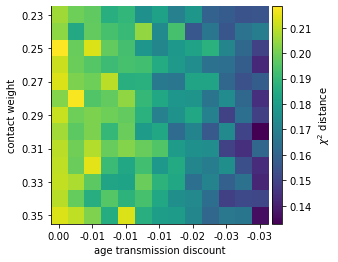

In [34]:
fig, ax = plt.subplots(figsize=(6, 4))

im = ax.imshow(img_first_component)
ax.set_yticks(range(len(contact_weights_veryfine))[::2])
ax.set_yticklabels(['{:1.2f}'.format(cw) for \
                    cw in contact_weights_veryfine[::2]])
ax.set_xticks(range(len(age_transmission_discounts_veryfine))[::2])
ax.set_xticklabels(['{:1.2f}'.format(atd) for \
                    atd in age_transmission_discounts_veryfine[::2]])

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('$\chi^2$ distance')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('contact weight')
ax.set_xlabel('age transmission discount')

plt.savefig('../../data/plots/calibration/first_component.pdf')

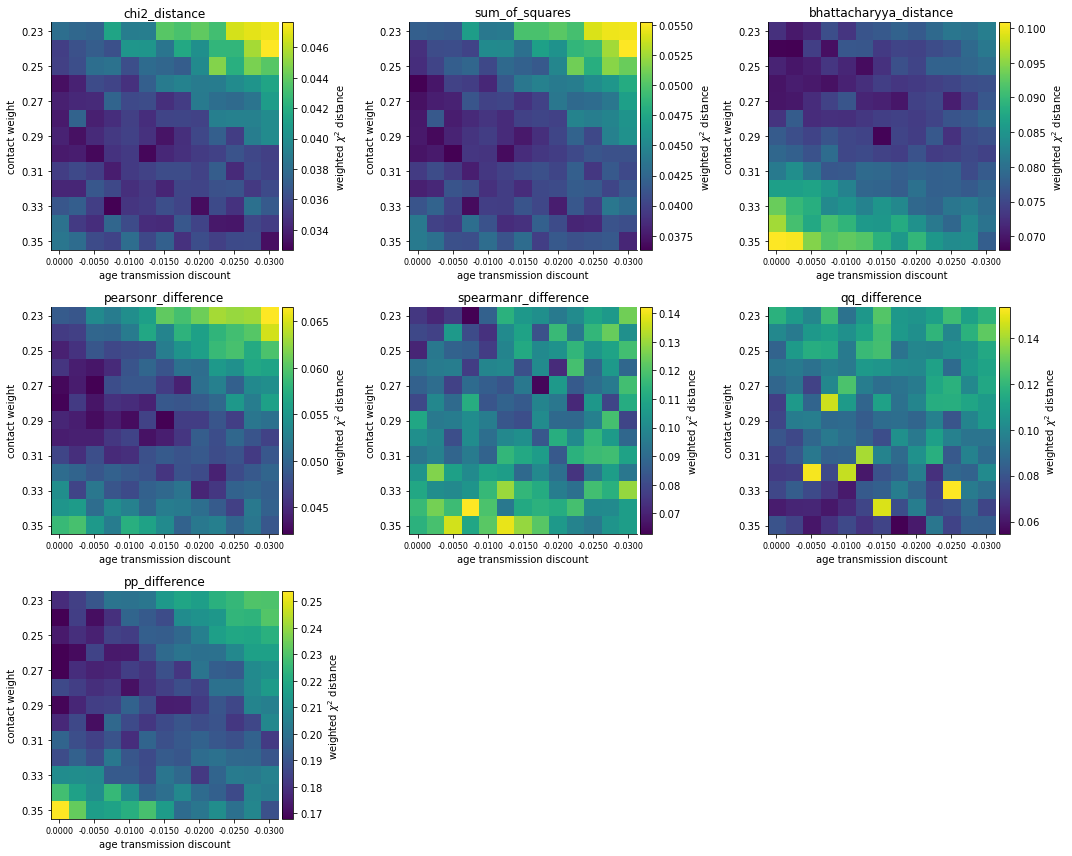

In [37]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for ax, col in zip(axes.flatten(), distance_cols):
    img_veryfine = distance_images[col]
    im = ax.imshow(img_veryfine)
    ax.set_yticks(range(len(contact_weights_veryfine))[::2])
    ax.set_yticklabels(['{:1.2f}'.format(cw) for \
                        cw in contact_weights_veryfine[::2]])
    ax.set_xticks(range(len(age_transmission_discounts_veryfine))[::2])
    ax.set_xticklabels(['{:1.4f}'.format(atd) for \
                        atd in age_transmission_discounts_veryfine[::2]],
                        fontsize=8)
    ax.set_title(col)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('weighted $\chi^2$ distance')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylabel('contact weight')
    ax.set_xlabel('age transmission discount')

axes[2, 1].axis('off')
axes[2, 2].axis('off')
fig.tight_layout()
plt.savefig('../../data/plots/calibration/distances_heatmap.pdf')

#### Calculate distance metrics for teacher and student distributions

In [38]:
# calculate the various distribution distances between the simulated and
# observed outbreak size distributions
src = '../../data/calibration/simulation_results/ensembles_veryfine_infected'

results_veryfine = pd.DataFrame()
for i, ep in enumerate(screening_params):
    _, school_type, icw, fcw, atd = ep
    if i % 100 == 0:
        print('{}/{}'.format(i, len(screening_params)))
    fname = 'school_type-{}_icw-{:1.2f}_fcw-{:1.2f}_atd-{:1.4f}_infected.csv'\
        .format(school_type, icw, fcw, atd)
    ensemble_results = pd.read_csv(join(src, fname), 
            dtype={'infected_students':int, 'infected_teachers':int,
                   'infected_total':int, 'run':int})
    row = cf.calculate_distances_two_distributions(ensemble_results, school_type,
            icw, fcw, atd, outbreak_sizes, group_distributions)
    
    results_veryfine = results_veryfine.append(row, ignore_index=True)

0/1014
100/1014
200/1014
300/1014
400/1014
500/1014
600/1014
700/1014
800/1014
900/1014
1000/1014


In [39]:
results_veryfine = results_veryfine.sort_values(by=['school_type',
                'intermediate_contact_weight', 'age_transmission_discount'])
results_veryfine = results_veryfine.reset_index(drop=True)

for agent_type in ['student', 'teacher']:
    results_veryfine['chi2_distance_{}_weighted'.format(agent_type)] = \
        results_veryfine['chi2_distance_{}'.format(agent_type)]
    for i, row in results_veryfine.iterrows():
        st = row['school_type']
        weight = counts.loc[st, 'weight']
        error = row['chi2_distance_{}'.format(agent_type)]
        results_veryfine.loc[i, 'chi2_distance_{}_weighted'.format(agent_type)] \
            = error * weight

##### Aggretage results for teacher and student distributions

In [40]:
agg_results_veryfine = results_veryfine\
    .drop(columns=['far_contact_weight'])\
    .rename(columns={'intermediate_contact_weight':'contact_weight'})\
    .groupby(['contact_weight',
              'age_transmission_discount'])\
    .sum()

for agent_type in ['student', 'teacher']:
    print(agent_type)
    opt_veryfine = agg_results_veryfine.loc[\
            agg_results_veryfine['chi2_distance_{}_weighted'.format(agent_type)]\
                                            .idxmin()].name
    opt_contact_weight_veryfine = opt_veryfine[0]
    opt_age_transmission_discount_veryfine = opt_veryfine[1]

    print('optimal grid search parameter combination:')
    print('\t contact weight: {:1.3f}'\
          .format(opt_contact_weight_veryfine))
    print('\t age transmission discount: {:1.4f}'\
          .format(opt_age_transmission_discount_veryfine))
    print()

student
optimal grid search parameter combination:
	 contact weight: 0.320
	 age transmission discount: 0.0000

teacher
optimal grid search parameter combination:
	 contact weight: 0.350
	 age transmission discount: 0.0000



In [41]:
agent_type_images = {}
for agent_type in ['student', 'teacher']:
    img_veryfine = np.zeros((len(contact_weights_veryfine),
                    len(age_transmission_discounts_veryfine)))
    for i, cw in enumerate(contact_weights_veryfine):
        for j, atd in enumerate(age_transmission_discounts_veryfine):
            cw = round(cw, 2)
            atd = round(atd, 4)
            try:
                img_veryfine[i, j] = agg_results_veryfine\
                    .loc[cw, atd]['chi2_distance_{}_weighted'.format(agent_type)]
            except KeyError:
                print(atd)
                img_veryfine[i, j] = np.nan
    agent_type_images[agent_type] = img_veryfine

In [42]:
agg_results_veryfine_schools = results_veryfine\
    .drop(columns=['far_contact_weight'])\
    .rename(columns={'intermediate_contact_weight':'contact_weight'})\
    .groupby(['contact_weight',
              'age_transmission_discount', 'school_type'])\
    .sum()

##### Plot results for teacher and student distributions

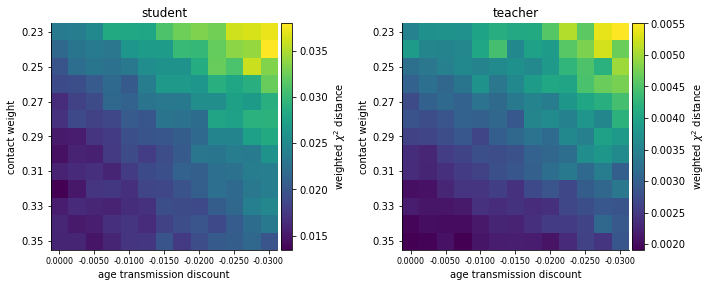

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

for ax, agent_type in zip(axes.flatten(), ['student', 'teacher']):
    img_veryfine = agent_type_images[agent_type]
    im = ax.imshow(img_veryfine)
    ax.set_yticks(range(len(contact_weights_veryfine))[::2])
    ax.set_yticklabels(['{:1.2f}'.format(cw) for \
                        cw in contact_weights_veryfine[::2]])
    ax.set_xticks(range(len(age_transmission_discounts_veryfine))[::2])
    ax.set_xticklabels(['{:1.4f}'.format(atd) for \
                        atd in age_transmission_discounts_veryfine[::2]],
                        fontsize=8)
    ax.set_title(agent_type)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('weighted $\chi^2$ distance')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylabel('contact weight')
    ax.set_xlabel('age transmission discount')

fig.tight_layout()
plt.savefig('../../data/plots/calibration/groups_heatmap.pdf')

##### Aggregate results for individual school types

In [44]:
agent_type_images_schools = {st:{} for st in school_types}


for st in school_types:
    for agent_type in ['student', 'teacher']:
        img_veryfine = np.zeros((len(contact_weights_veryfine),
                        len(age_transmission_discounts_veryfine)))
        for i, cw in enumerate(contact_weights_veryfine):
            for j, atd in enumerate(age_transmission_discounts_veryfine):
                cw = round(cw, 2)
                atd = round(atd, 4)
                try:
                    img_veryfine[i, j] = agg_results_veryfine_schools\
                        .loc[cw, atd, st]['chi2_distance_{}'.format(agent_type)]
                except KeyError:
                    print(atd)
                    img_veryfine[i, j] = np.nan
        agent_type_images_schools[st][agent_type] = img_veryfine

##### Plot results for individual school types

In [45]:
agent_type_images_schools['primary']['student'].mean() * 0.077367

0.00810343985131171

In [46]:
agent_type_images_schools['primary_dc']['student'].mean() * 0.077367

0.0055471160786372264

In [47]:
agent_type_images_schools['lower_secondary']['student'].mean() * 0.207852

0.0018095410667955446

In [48]:
agent_type_images_schools['lower_secondary_dc']['student'].mean() * 0.207852

0.002315971304898879

In [49]:
agent_type_images_schools['upper_secondary']['student'].mean() * 0.267898

0.0024705819302235396

In [50]:
agent_type_images_schools['secondary']['student'].mean() * 0.161

0.002203623191137639

In [51]:
# contribution of the primary school error term to the overall distance metric
(0.008071472056009546 + 0.005494417873311884) / \
    (0.008071472056009546 + 0.005494417873311884 + 0.001690039483497032 + 0.0022012108579205114 + 0.002572723952158654 + 0.0020909021660216465)

0.6132649154559514

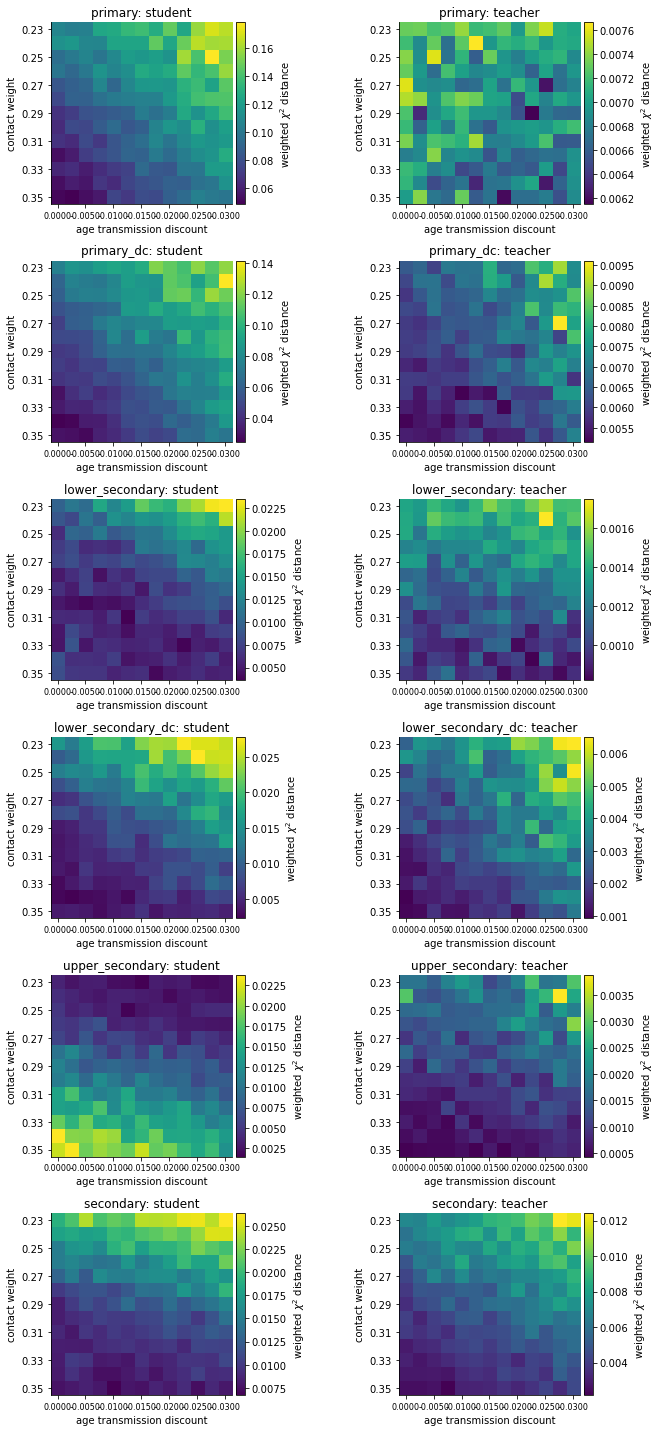

In [52]:
fig, axes = plt.subplots(6, 2, figsize=(10, 20))
plot_types = [(st, at) for st in school_types for at in ['student', 'teacher']]

for ax, pt in zip(axes.flatten(), plot_types):
    school_type, agent_type = pt
    
    img_veryfine = agent_type_images_schools[school_type][agent_type]
    im = ax.imshow(img_veryfine)
    ax.set_yticks(range(len(contact_weights_veryfine))[::2])
    ax.set_yticklabels(['{:1.2f}'.format(cw) for \
                        cw in contact_weights_veryfine[::2]])
    ax.set_xticks(range(len(age_transmission_discounts_veryfine))[::2])
    ax.set_xticklabels(['{:1.4f}'.format(atd) for \
                        atd in age_transmission_discounts_veryfine[::2]],
                        fontsize=8)
    ax.set_title('{}: {}'.format(school_type, agent_type))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('weighted $\chi^2$ distance')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylabel('contact weight')
    ax.set_xlabel('age transmission discount')

fig.tight_layout()
plt.savefig('../../data/plots/calibration/groups_schools_heatmap.pdf')

### Analyze the very fine grid search only Chi²

#### Collect the results

In [53]:
dst = '../../data/calibration/simulation_results'
N = 4000

# contact weight 0.27 had an incorrect result for the first run, because the 
# simulations were accidentally run twice and results summed.
# We therefore re-run simulations for cw=0.27 and combine the data from the 
# original run and the re-run here
results_veryfine_ensmbl = pd.DataFrame()
for st in school_types:
    tmp = pd.read_csv(join(dst, 'calibration_results_veryfine_sampling_{}_{}.csv'\
                          .format(N, st)))
    results_veryfine_ensmbl = pd.concat([results_veryfine_ensmbl, tmp])
    
results_veryfine_rerun = pd.DataFrame()
for st in school_types:
    tmp = pd.read_csv(join(dst, 'calibration_results_veryfine_rerun_sampling_{}_{}.csv'\
                          .format(N, st)))
    results_veryfine_rerun = pd.concat([results_veryfine_rerun, tmp])
    
results_veryfine_ensmbl = results_veryfine_ensmbl[results_veryfine_ensmbl['intermediate_contact_weight'] != 0.27]
results_veryfine_ensmbl = pd.concat([results_veryfine_ensmbl, results_veryfine_rerun])

results_veryfine.to_csv(join(dst, 'calibration_results_veryfine_sampling_{}.csv'\
                        .format(N)), index=False)

In [54]:
results_veryfine_ensmbl = results_veryfine_ensmbl.sort_values(by=['school_type',
                'intermediate_contact_weight', 'age_transmission_discount'])
results_veryfine_ensmbl = results_veryfine_ensmbl.reset_index(drop=True)

results_veryfine_ensmbl['chi2_distance_total'] = \
        results_veryfine_ensmbl['chi2_distance_size'] + \
        results_veryfine_ensmbl['sum_of_squares_distro']

results_veryfine_ensmbl['chi2_distance_total_weighted'] = \
        results_veryfine_ensmbl['chi2_distance_total']

for i, row in results_veryfine_ensmbl.iterrows():
    #print(i, row['school_type'], row['age_transmission_discount'], row['intermediate_contact_weight'])
    st = row['school_type']
    weight = counts.loc[st, 'weight']
    error = row['chi2_distance_total']
    #print(error * weight)
    results_veryfine_ensmbl.loc[i, 'chi2_distance_total_weighted'] = error * weight

#### Aggretage results

In [55]:
agg_results_veryfine_ensmbl = results_veryfine_ensmbl\
    .drop(columns=['far_contact_weight'])\
    .rename(columns={'intermediate_contact_weight':'contact_weight'})\
    .groupby(['contact_weight',
              'age_transmission_discount'])\
    .sum()
opt_veryfine_ensmbl = agg_results_veryfine_ensmbl.loc[\
        agg_results_veryfine_ensmbl['chi2_distance_total_weighted'].idxmin()].name
opt_contact_weight_veryfine_ensmbl = opt_veryfine_ensmbl[0]
opt_age_transmission_discount_veryfine_ensmbl = opt_veryfine_ensmbl[1]

print('optimal grid search parameter combination:')
print('\t contact weight: {:1.3f}'\
      .format(opt_contact_weight_veryfine_ensmbl))
print('\t age transmission discount: {:1.4f}'\
      .format(opt_age_transmission_discount_veryfine_ensmbl))

optimal grid search parameter combination:
	 contact weight: 0.330
	 age transmission discount: -0.0075


In [56]:
img_veryfine_ensmbl = np.zeros((len(contact_weights_veryfine),
                len(age_transmission_discounts_veryfine)))
for i, cw in enumerate(contact_weights_veryfine):
    for j, atd in enumerate(age_transmission_discounts_veryfine):
        cw = round(cw, 2)
        atd = round(atd, 4)
        try:
            img_veryfine_ensmbl[i, j] = agg_results_veryfine_ensmbl\
                .loc[cw, atd]['chi2_distance_total_weighted']
        except KeyError:
            print(atd)
            img_veryfine_ensmbl[i, j] = np.nan

#### Plot results aggregated

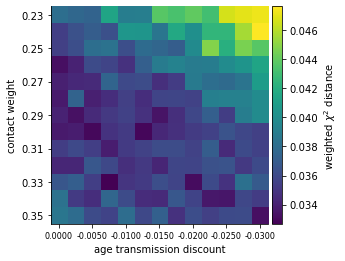

In [57]:
fig, ax = plt.subplots(figsize=(6, 4))

im = ax.imshow(img_veryfine_ensmbl)
ax.set_yticks(range(len(contact_weights_veryfine))[::2])
ax.set_yticklabels(['{:1.2f}'.format(cw) for \
                    cw in contact_weights_veryfine[::2]])
ax.set_xticks(range(len(age_transmission_discounts_veryfine))[::2])
ax.set_xticklabels(['{:1.4f}'.format(atd) for \
                    atd in age_transmission_discounts_veryfine[::2]],
                    fontsize=8)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('weighted $\chi^2$ distance')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('contact weight')
ax.set_xlabel('age transmission discount')
plt.savefig('../../data/plots/calibration/error_term_heatmap.pdf')

#### Plot results separated by school types

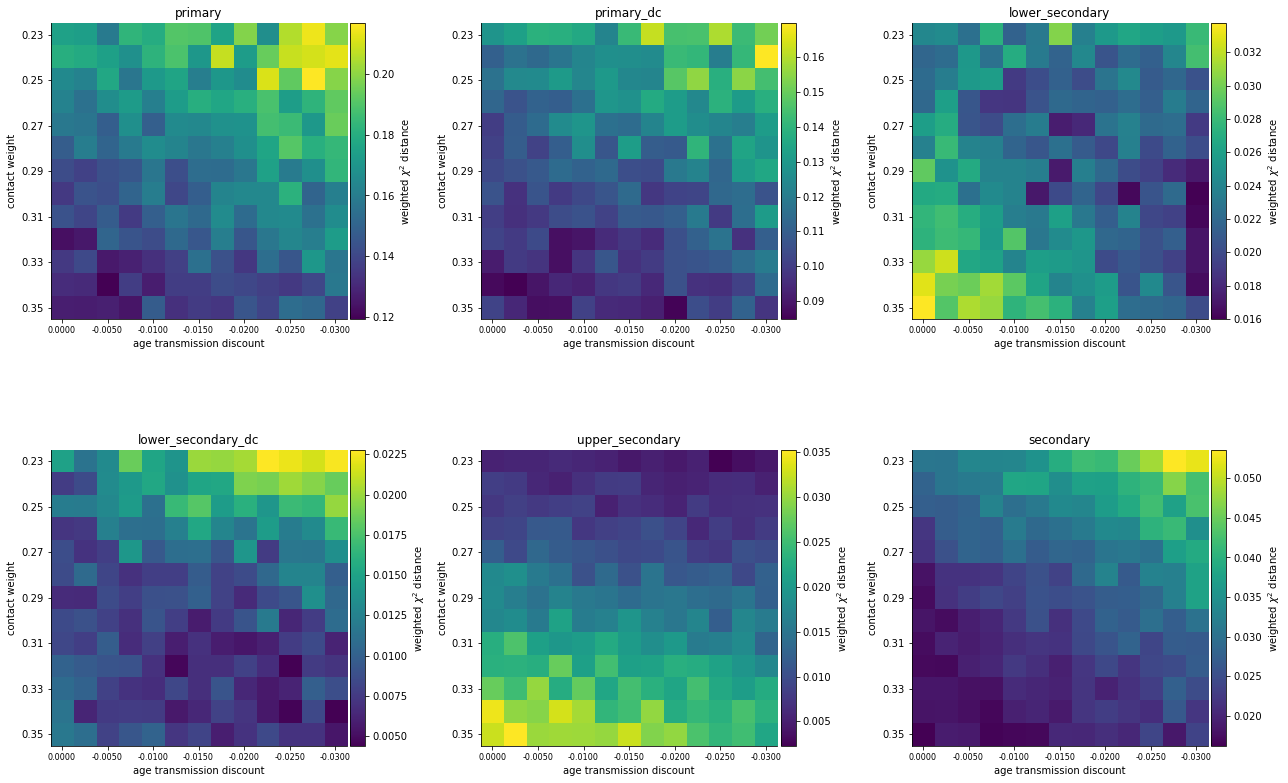

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

results_veryfine_indexed = results_veryfine_ensmbl.set_index(['school_type', 
                    'intermediate_contact_weight', 'age_transmission_discount'])

for st, ax in zip(school_types, axes.flatten()):
    
    img_st = np.zeros((len(contact_weights_veryfine),
                len(age_transmission_discounts_veryfine)))
    for i, cw in enumerate(contact_weights_veryfine):
        for j, atd in enumerate(age_transmission_discounts_veryfine):
            cw = round(cw, 2)
            atd = round(atd, 4)
            try:
                img_st[i, j] = results_veryfine_indexed\
                    .loc[st, cw, atd]['chi2_distance_total']
            except KeyError:
                print(atd)
                img_st[i, j] = np.nan
    
    im = ax.imshow(img_st)
    ax.set_yticks(range(len(contact_weights_veryfine))[::2])
    ax.set_yticklabels(['{:1.2f}'.format(cw) for \
                        cw in contact_weights_veryfine[::2]])
    ax.set_xticks(range(len(age_transmission_discounts_veryfine))[::2])
    ax.set_xticklabels(['{:1.4f}'.format(atd) for \
                        atd in age_transmission_discounts_veryfine[::2]],
                        fontsize=8)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('weighted $\chi^2$ distance')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylabel('contact weight')
    ax.set_xlabel('age transmission discount')
    ax.set_title(st)
fig.tight_layout()
plt.savefig('../../data/plots/calibration/error_term_heatmaps_schooltypes.pdf')

#### Plot results errorterm lineplots

atd: 0.0000, min: 0.0333, cw: 0.2600
atd: -0.0025, min: 0.0333, cw: 0.2900
atd: -0.0050, min: 0.0330, cw: 0.3000
atd: -0.0075, min: 0.0327, cw: 0.3300
atd: -0.0100, min: 0.0347, cw: 0.3200
atd: -0.0125, min: 0.0329, cw: 0.3000
atd: -0.0150, min: 0.0335, cw: 0.2900
atd: -0.0175, min: 0.0347, cw: 0.2900
atd: -0.0200, min: 0.0332, cw: 0.3300
atd: -0.0225, min: 0.0336, cw: 0.3400
atd: -0.0250, min: 0.0336, cw: 0.3400
atd: -0.0275, min: 0.0352, cw: 0.3200
atd: -0.0300, min: 0.0333, cw: 0.3500


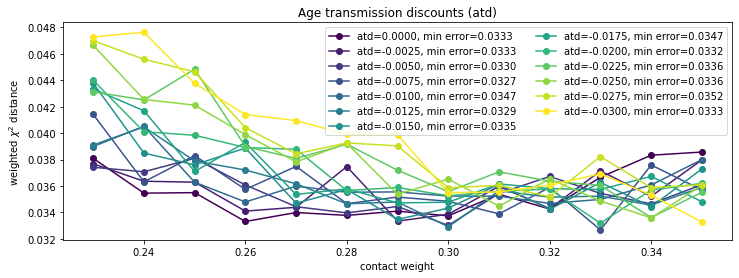

In [60]:
agg_results_selection_veryfine = agg_results_veryfine_ensmbl.copy().reset_index()

fig, ax = plt.subplots(figsize=(12,4))
cmap = plt.get_cmap('viridis')

for i, atd_level in enumerate(age_transmission_discounts_veryfine):
    atd_level = round(atd_level, 4)
    agg_results_level = agg_results_selection_veryfine[\
        agg_results_selection_veryfine['age_transmission_discount'] == atd_level]\
        .reset_index(drop=True)
    
    ax.plot(agg_results_level['contact_weight'],
            agg_results_level['chi2_distance_total_weighted'],
            'o-', color=cmap(i/(len(contact_weights_veryfine) - 1)),
            label='atd={:1.4f}, min error={:1.4f}'\
                .format(atd_level, agg_results_level['chi2_distance_total_weighted'].min()))
    
    min_cw = agg_results_level.loc[agg_results_level['chi2_distance_total_weighted'].idxmin()]['contact_weight']
    print('atd: {:1.4f}, min: {:1.4f}, cw: {:1.4f}'\
          .format(atd_level, agg_results_level['chi2_distance_total_weighted'].min(), min_cw))
    
ax.set_ylabel('weighted $\chi^2$ distance')
ax.set_xlabel('contact weight')
ax.legend(ncol=2, loc=0)
ax.set_title('Age transmission discounts (atd)')
plt.savefig('../../data/plots/calibration/error_term_lineplot.pdf');

#### Plot results fit plane

In [176]:
%matplotlib widget
import scipy
data = agg_results_veryfine_ensmbl[['chi2_distance_total_weighted']].reset_index().values

# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(data[0:,0].min() - 0.025, data[0:,0].max() + 0.025, 0.01),
                  np.arange(data[0:,1].min(), data[0:,1].max() + 0.001, 0.001))
XX = X.flatten()
YY = Y.flatten()

A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
# evaluate it on a grid
Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

# plot points and fitted surface
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='b', s=10)

intermediate_opt, far_opt = np.unravel_index(Z.argmin(), Z.shape)
intermediate_range = np.arange(data[0:,0].min() - 0.05, data[0:,0].max() + 0.05, 0.01)
far_range = np.arange(data[0:,1].min() - 0.05, data[0:,1].max() + 0.05, 0.01)

#ax.scatter([intermediate_range[intermediate_opt]], [far_range[far_opt]],
#           [Z.min()], c='b', s=30)
#ax.scatter(data[0, 0], data[0, 1], data[0, 2], c='b', s=30)
ax.scatter(XX[np.argmin(Z)], YY[np.argmin(Z)], Z.min(), s=50, c='r')

print('min: ({:1.4f}, {:1.4f}, {:1.4f})'.format(XX[np.argmin(Z)], YY[np.argmin(Z)], Z.min()))

plt.xlabel('contact weight')
plt.ylabel('age transmission modification')
ax.set_zlabel('error term')
#ax.axis('equal')
#ax.axis('tight')
plt.show()
plt.savefig('../../data/plots/calibration/error_term_surfaceplot.pdf');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

min: (0.2850, 0.0000, 0.0342)
